# Import Libraries

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE


# Load Dataset

In [15]:
df=pd.read_csv('synthetic_loan_data.csv')
df

,CustomerID,Name,Age,Gender,MaritalStatus,EducationLevel,EmploymentStatus,AnnualIncome,LoanAmountRequested,PurposeOfLoan,CreditScore,ExistingLoansCount,LatePaymentsLastYear,LoanApproved
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,Michelle Prince,56,Male,Divorced,Other,Employed,97622,46413,Personal,500,2,4,Yes
1,23b8c1e9-3924-46de-beb1-3b9046685257,Diana Mullins,69,Male,Married,Bachelor,Employed,96925,24065,Home,532,2,0,Yes
2,bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9,Brittany Ballard,46,Female,Single,High School,Self-employed,167927,46676,Personal,795,2,6,Yes
3,972a8469-1641-4f82-8b9d-2434e465e150,Matthew Freeman,32,Female,Widowed,PhD,Unemployed,112920,27406,Education,376,2,9,No
4,17fc695a-07a0-4a6e-8822-e8f36c031199,Amy Baker,60,Female,Widowed,Master,Unemployed,152183,49337,Car,517,3,7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,bdcfc42b-8122-41db-aa6a-58b294568b74,Jose Torres,22,Female,Divorced,Other,Student,178359,48541,Education,363,2,8,Yes
8996,a874d557-cd0e-4708-acbf-81d4b1720b65,Michael Butler,26,Female,Widowed,Other,Self-employed,126938,33411,Education,379,4,7,Yes
8997,8a4f48b2-d251-43ad-880b-dbd7657050ee,Veronica Avila,19,Male,Married,PhD,Student,119957,47023,Car,693,2,6,Yes
8998,8d5af123-085d-47e6-872c-5869d4c933f2,Kayla Miller,51,Female,Married,PhD,Retired,160226,31385,Personal,649,4,7,No


# Check Missing values

In [16]:
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
CustomerID              0
Name                    0
Age                     0
Gender                  0
MaritalStatus           0
EducationLevel          0
EmploymentStatus        0
AnnualIncome            0
LoanAmountRequested     0
PurposeOfLoan           0
CreditScore             0
ExistingLoansCount      0
LatePaymentsLastYear    0
LoanApproved            0
dtype: int64


# Handling Outliers

In [17]:
# Select only numerical columns for outlier detection
numerical_cols = df.select_dtypes(include=np.number).columns

# Define a function to detect outliers using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Check each numerical column for outliers and print the columns with outliers
cols_with_outliers = []
for col in numerical_cols:
    outliers = detect_outliers_iqr(df, col)
    if not outliers.empty:
        cols_with_outliers.append(col)

print("Columns with outliers (using IQR method):")
print(cols_with_outliers)

Columns with outliers (using IQR method):
[]


# Label Encoding

In [18]:
# Copy to preserve original data
df_encoded = df.copy()

# List of categorical columns to encode (excluding CustomerID and Name)
categorical_cols = [
    "Gender",
    "MaritalStatus",
    "EducationLevel",
    "EmploymentStatus",
    "PurposeOfLoan",
    "LoanApproved"
]

# Dictionary to store the encoders (optional, useful for inverse_transform)
label_encoders = {}

# Apply label encoding
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Preview the encoded DataFrame
print(df_encoded.head())

                             CustomerID              Name  Age  Gender  \
0  bdd640fb-0667-4ad1-9c80-317fa3b1799d   Michelle Prince   56       1   
1  23b8c1e9-3924-46de-beb1-3b9046685257     Diana Mullins   69       1   
2  bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9  Brittany Ballard   46       0   
3  972a8469-1641-4f82-8b9d-2434e465e150   Matthew Freeman   32       0   
4  17fc695a-07a0-4a6e-8822-e8f36c031199         Amy Baker   60       0   

   MaritalStatus  EducationLevel  EmploymentStatus  AnnualIncome  \
0              0               3                 0         97622   
1              1               0                 0         96925   
2              2               1                 2        167927   
3              3               4                 4        112920   
4              3               2                 4        152183   

   LoanAmountRequested  PurposeOfLoan  CreditScore  ExistingLoansCount  \
0                46413              4          500                   2  

# Encoding & Applying SMOTE

In [27]:
# Encode categorical columns
categorical_cols = [
    "Gender", "MaritalStatus", "EducationLevel",
    "EmploymentStatus", "PurposeOfLoan", "LoanApproved"
]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop(["CustomerID", "Name", "LoanApproved"], axis=1)
y = df["LoanApproved"]

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Applying Logistic Regression & Decision Tree

In [28]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_smote, y_train_smote)
y_pred_log = log_reg.predict(X_test)

# Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_smote, y_train_smote)
y_pred_tree = tree_clf.predict(X_test)

# Print metrics
print("=== Logistic Regression ===")
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log))

print("\n=== Decision Tree ===")
print("Precision:", precision_score(y_test, y_pred_tree))
print("Recall:", recall_score(y_test, y_pred_tree))
print("F1 Score:", f1_score(y_test, y_pred_tree))

=== Logistic Regression ===
Precision: 0.6991869918699187
Recall: 0.6137985725614592
F1 Score: 0.6537162162162162

=== Decision Tree ===
Precision: 0.7045028142589118
Recall: 0.5955590800951626
F1 Score: 0.6454662655779975


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Model Performance

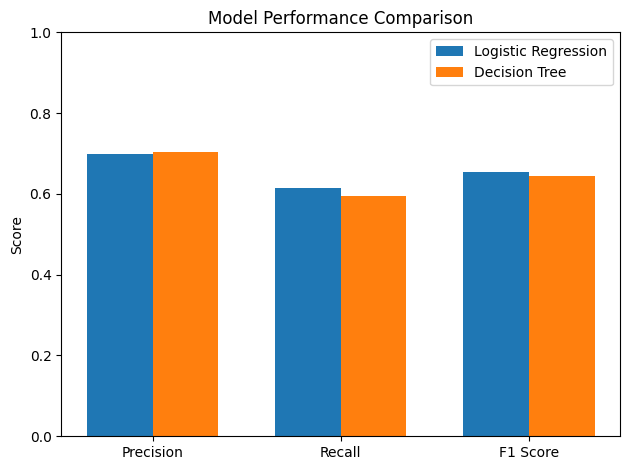

In [23]:

# Replace these with your model predictions if running from scratch
logistic_scores = [
    precision_score(y_test, y_pred_log),
    recall_score(y_test, y_pred_log),
    f1_score(y_test, y_pred_log)
]
tree_scores = [
    precision_score(y_test, y_pred_tree),
    recall_score(y_test, y_pred_tree),
    f1_score(y_test, y_pred_tree)
]

metrics = ['Precision', 'Recall', 'F1 Score']
x = range(len(metrics))
width = 0.35

plt.bar([i - width/2 for i in x], logistic_scores, width=width, label='Logistic Regression')
plt.bar([i + width/2 for i in x], tree_scores, width=width, label='Decision Tree')

plt.xticks(ticks=x, labels=metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()


# Training & Prediction of Model

In [25]:
# Identify and encode categorical columns
categorical_cols = [
    "Gender",
    "MaritalStatus",
    "EducationLevel",
    "EmploymentStatus",
    "PurposeOfLoan",
    "LoanApproved"
]

# Apply label encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders if you want to decode later

# Define features and target
X = df.drop(["CustomerID", "Name", "LoanApproved"], axis=1)
y = df["LoanApproved"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Show original class distribution
print("Original class distribution:\n", y_train.value_counts())

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluation
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Original class distribution:
 LoanApproved
1    5042
0    2158
Name: count, dtype: int64

Confusion Matrix:
 [[145 394]
 [317 944]]

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.27      0.29       539
           1       0.71      0.75      0.73      1261

    accuracy                           0.60      1800
   macro avg       0.51      0.51      0.51      1800
weighted avg       0.59      0.60      0.60      1800



# Bar Chart of Loan Approval Distribution

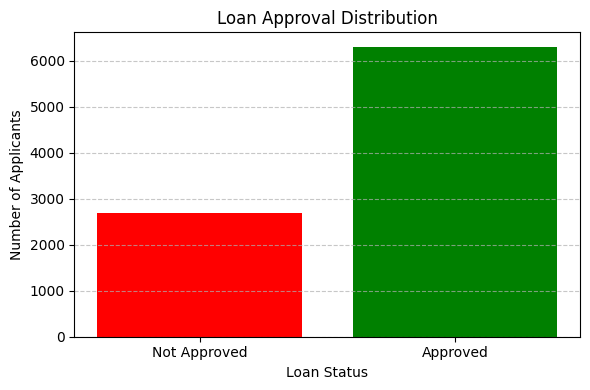

In [26]:
import matplotlib.pyplot as plt

# Count values in the 'LoanApproved' column
approval_counts = df["LoanApproved"].value_counts().sort_index()

# Decode the labels (optional - only if you used LabelEncoder)
# approval_labels = label_encoders["LoanApproved"].inverse_transform(approval_counts.index)
approval_labels = ['Not Approved', 'Approved']  # 0 -> No, 1 -> Yes (based on encoding)

# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(approval_labels, approval_counts, color=['red', 'green'])
plt.title("Loan Approval Distribution")
plt.ylabel("Number of Applicants")
plt.xlabel("Loan Status")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
